In [3]:
from tessreduce import *
import tessreduce as tr
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np

In [4]:
ra = 269.0488792
dec = 62.75700278
sector = 21
size = 90

In [5]:
tess = tr.tessreduce(ra=ra,dec=dec,size=size,sector=sector)

In [7]:
tess.get_ref()
if tess.verbose > 0:
    print('made reference')
# make source mask
tess.Make_mask(maglim=18,strapsize=4,scale=1)#Source_mask(ref,grid=0)
frac = np.nansum((tess.mask == 0) * 1.) / (tess.mask.shape[0] * tess.mask.shape[1])
print('mask frac ',frac)
if frac < 0.2:
    print('!!!WARNING!!! mask is too dense, lowering mask_scale to 0.5, and raising maglim to 15. Background quality will be reduced.')
    tess.Make_mask(maglim=15,strapsize=4,scale=0.5)
if tess.verbose > 0:
    print('made source mask')

True
made reference
mask frac  0.08358024691358025
!!!WARNING!!! mask is too dense, lowering mask_scale to 0.5, and raising maglim to 15. Background quality will be reduced.
made source mask


In [9]:
m = (tess.mask == 0) * 1.
m[m==0] = np.nan

if (tess.flux.shape[1] > 30) & (tess.flux.shape[2] > 30):
    flux = strip_units(tess.flux)

    bkg_smth = np.zeros_like(flux) * np.nan
    if tess.parallel:
        num_cores = multiprocessing.cpu_count()
        bkg_smth = Parallel(n_jobs=num_cores)(delayed(Smooth_bkg)(frame) for frame in flux*m)
    else:
        for i in range(flux.shape[0]):
            bkg_smth[i] = Smooth_bkg(flux[i]*m)
else:
    print('Small tpf, using percentile cut background')
    bkg_smth = tess.Small_background()



<IPython.core.display.Javascript object>


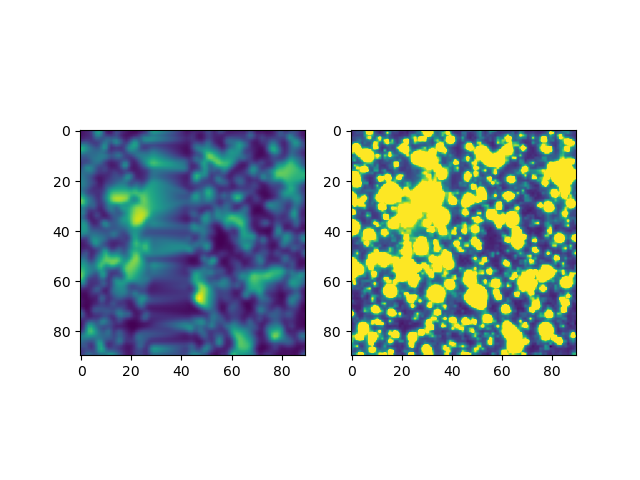

In [13]:
plt.figure()
plt.subplot(121)
plt.imshow(bkg_smth[100])
plt.subplot(122)
plt.imshow(tess.flux[100],vmax=100)

In [23]:
m = ((tess.mask | 4) == 4)*1.

In [21]:
m

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

<IPython.core.display.Javascript object>


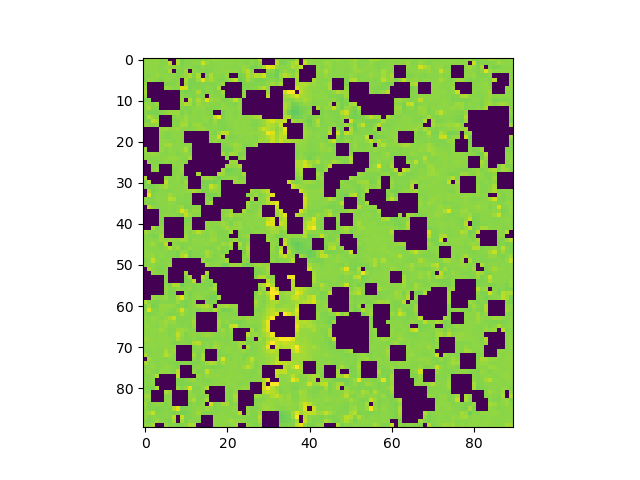

<IPython.core.display.Javascript object>


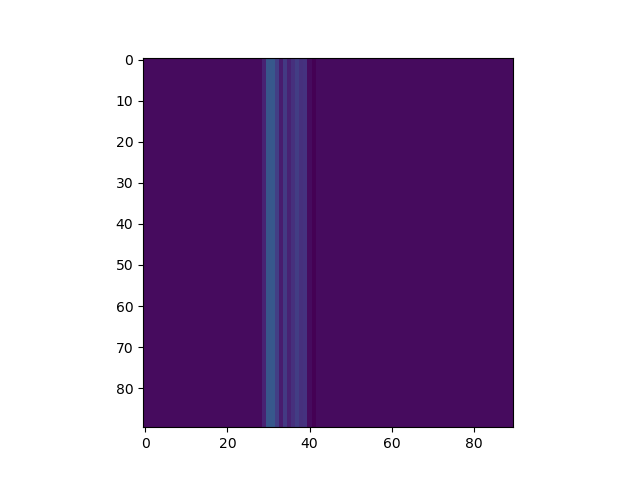

In [35]:
plt.figure()
plt.imshow(tess.flux[10]*m/bkg_smth[10],vmax=1.2)

plt.figure()
plt.imshow(qes[10],vmax=1.2)

In [34]:
strap = ((((tess.mask & 4) * ((tess.mask | 4) == 4))) > 0) * 1.0
strap[strap==0] = np.nan

data = strip_units(tess.flux)
qes = np.zeros_like(bkg_smth) * np.nan
for i in range(data.shape[0]):
    s = (data[i]*strap)/bkg_smth[i]
    q = np.zeros_like(s) * np.nan
    for j in range(s.shape[1]):
        q[:,j] = np.nanmedian(abs(s[:,j]))
    q[np.isnan(q)] =1 
    qes[i] = q
bkg = bkg_smth * qes


In [29]:
strap

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])